# *Importing Libraries:*

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Softmax, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# *Preprocessing:*


In [2]:
path = 'Multi-class Weather Dataset/'
folders = os.listdir(path)
print(folders)

['Cloudy', 'Rain', 'Shine', 'Sunrise']


In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,)

train_generator = datagen.flow_from_directory(
    path,
    target_size=(250,250),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='training')

validation_generator = datagen.flow_from_directory(
    path,
    target_size=(250,250),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='validation')

Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


### Show sample:

In [4]:
classes = list(train_generator.class_indices.keys())
img, lable = train_generator.next()
img.shape

(32, 250, 250, 3)

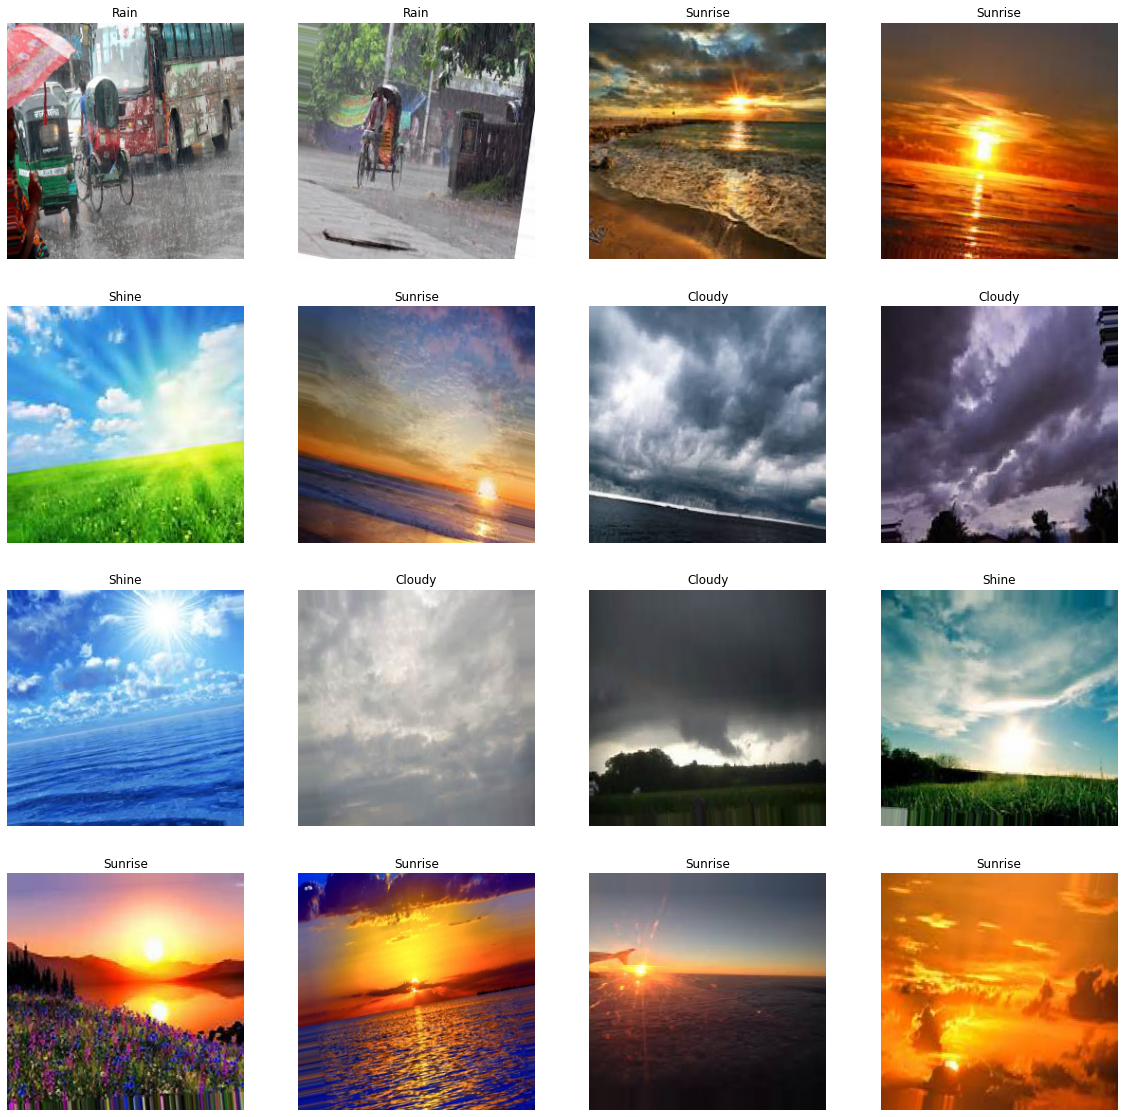

In [5]:
plt.figure(figsize= (20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[i])
    index = np.argmax(lable[i]) 
    class_name = classes[index]
    plt.title(class_name)
    plt.axis('off')
plt.show()

In [6]:
def draw_plot(history, history_ft = None, fine_tune = False):
    acc = []
    val_acc = []
    loss = []
    val_loss = []

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    if not fine_tune:
        plt.figure(figsize=(8, 8))
        plt.subplot(2, 1, 1)
        plt.plot(acc, label='Training Accuracy', color='darkblue')
        plt.plot(val_acc, label='Validation Accuracy', color='deeppink')
        plt.legend(loc='lower right')
        plt.ylabel('Accuracy')
        plt.ylim([min(plt.ylim()), 1])
        plt.xlim([-1, initial_epochs + 1])
        plt.title('Training and Validation Accuracy')

        plt.subplot(2, 1, 2)
        plt.plot(loss, label='Training Loss', color='darkblue')
        plt.plot(val_loss, label='Validation Loss', color='deeppink')
        plt.legend(loc='upper right')
        plt.ylabel('Cross Entropy')
        plt.ylim([0, 1.0])
        plt.xlim([-1, initial_epochs + 1])
        plt.title('Training and Validation Loss')
        plt.xlabel('epoch')
        plt.show()
    else:
        acc += history_ft.history['accuracy']
        val_acc += history_ft.history['val_accuracy']

        loss += history_ft.history['loss']
        val_loss += history_ft.history['val_loss']
        
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.plot(acc, label='Training Accuracy', color='darkblue')
        plt.plot(val_acc, label='Validation Accuracy', color='deeppink')
        plt.ylim([0.7, 1])
        plt.xlim([-1, initial_epochs + fine_tune_epochs + 1])
        plt.plot([initial_epochs, initial_epochs], plt.ylim(), label='Start Fine Tuning', color='g')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(2, 1, 2)
        plt.plot(loss, label='Training Loss', color='darkblue')
        plt.plot(val_loss, label='Validation Loss', color='deeppink')
        plt.ylim([0, 1.0])
        plt.xlim([-1, initial_epochs + fine_tune_epochs + 1])
        plt.plot([initial_epochs, initial_epochs], plt.ylim(), label='Start Fine Tuning', color='g')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('epoch')
        plt.show()
        
def print_confusion_matrix(y, y_pred):
    cm = confusion_matrix(y.classes, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Cloudy', 'Rain', 'Shine', 'Sunrise'])
    cmd.plot()
    plt.xlabel('Predicted Values', fontsize = 12)
    plt.ylabel('Actual Values', fontsize = 12)
    plt.show()

# *Model Structure:*

In [7]:
# global parameters:
initial_epochs = 15
fine_tune_epochs = 10
input_shape = (250, 250, 3)

LR = 1e-3
OPTIMIZER = Adamax(LR)
LOSS = CategoricalCrossentropy()
METRICS = ['accuracy']

## Dense Neural Network:

In [8]:
model_dnn = Sequential([
    Input(shape=(250, 250, 3)),
    Flatten(),
    
    Dense(128, 'relu'),
    BatchNormalization(),
    
    Dense(64, 'relu'),
    BatchNormalization(),
    
    Dense(32, 'relu'),
    BatchNormalization(),
    
    Dense(16, 'relu'),
    BatchNormalization(),
    
    Dense(8, 'relu'),
    BatchNormalization(),
    
    Dense(4, 'softmax')
])

model_dnn.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

In [9]:
model_dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 187500)            0         
                                                                 
 dense (Dense)               (None, 128)               24000128  
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 32)                2

In [10]:
hist_dnn = model_dnn.fit(train_generator, validation_data = validation_generator, epochs = 10, verbose = 2)

Epoch 1/10
29/29 - 21s - loss: 1.1892 - accuracy: 0.4817 - val_loss: 1.9408 - val_accuracy: 0.2500 - 21s/epoch - 738ms/step
Epoch 2/10
29/29 - 19s - loss: 0.9563 - accuracy: 0.5960 - val_loss: 1.2897 - val_accuracy: 0.3705 - 19s/epoch - 640ms/step
Epoch 3/10
29/29 - 19s - loss: 0.8874 - accuracy: 0.6404 - val_loss: 1.2591 - val_accuracy: 0.4688 - 19s/epoch - 657ms/step
Epoch 4/10
29/29 - 19s - loss: 0.8307 - accuracy: 0.6826 - val_loss: 1.0525 - val_accuracy: 0.5580 - 19s/epoch - 650ms/step
Epoch 5/10
29/29 - 19s - loss: 0.7929 - accuracy: 0.7059 - val_loss: 0.9666 - val_accuracy: 0.5446 - 19s/epoch - 640ms/step
Epoch 6/10
29/29 - 19s - loss: 0.7725 - accuracy: 0.6948 - val_loss: 2.1203 - val_accuracy: 0.2411 - 19s/epoch - 650ms/step
Epoch 7/10
29/29 - 19s - loss: 0.7523 - accuracy: 0.7248 - val_loss: 2.7553 - val_accuracy: 0.4018 - 19s/epoch - 648ms/step
Epoch 8/10
29/29 - 18s - loss: 0.7400 - accuracy: 0.7192 - val_loss: 0.9361 - val_accuracy: 0.6473 - 18s/epoch - 636ms/step
Epoch 9/

# *Convolutional Neural Network:*
### *Using Transfer Learning...*


## InceptionV3:

In [11]:
base_model_inc = tf.keras.applications.InceptionV3(input_shape = input_shape,
                                                   include_top = False,
                                                   weights = "imagenet"
                                                  )

In [12]:
base_model_inc.trainable = False

In [13]:
model_inc = Sequential([
    base_model_inc,
    MaxPooling2D(),
    BatchNormalization(),
    Flatten(),
    Dense(64, 'relu'),
    BatchNormalization(),
    Dense(len(classes), "softmax")
])

model_inc.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

In [14]:
model_inc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 3, 3, 2048)        0         
 g2D)                                                            
                                                                 
 batch_normalization_99 (Ba  (None, 3, 3, 2048)        8192      
 tchNormalization)                                               
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                1179712   
                                                                 
 batch_normalization_100 (B  (None, 64)               

In [15]:
len(model_inc.trainable_variables)

8

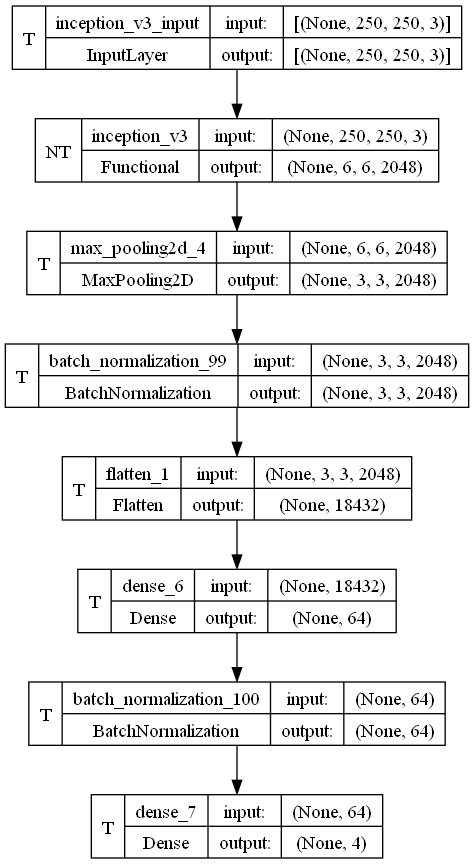

In [16]:
plot_model(model_inc, show_shapes = True, show_trainable = True)

In [17]:
hist_inc = model_inc.fit(train_generator, validation_data = validation_generator, epochs = initial_epochs, verbose = 2)

Epoch 1/15


KeyError: in user code:

    File "C:\Users\user\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\user\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\user\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\user\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1084, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\user\anaconda3\lib\site-packages\keras\src\optimizers\optimizer.py", line 544, in minimize
        self.apply_gradients(grads_and_vars)
    File "C:\Users\user\anaconda3\lib\site-packages\keras\src\optimizers\optimizer.py", line 1230, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "C:\Users\user\anaconda3\lib\site-packages\keras\src\optimizers\optimizer.py", line 652, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "C:\Users\user\anaconda3\lib\site-packages\keras\src\optimizers\optimizer.py", line 1260, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "C:\Users\user\anaconda3\lib\site-packages\keras\src\optimizers\optimizer.py", line 1352, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "C:\Users\user\anaconda3\lib\site-packages\keras\src\optimizers\optimizer.py", line 1349, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "C:\Users\user\anaconda3\lib\site-packages\keras\src\optimizers\optimizer.py", line 233, in _update_step
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable batch_normalization_99/gamma:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adamax.'


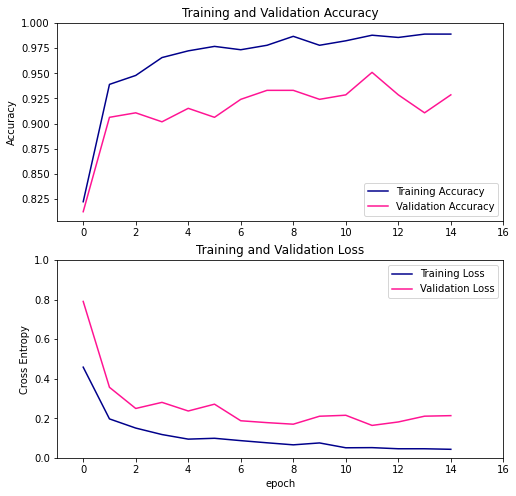

In [41]:
draw_plot(hist_inc)

## Fine Tuning

In [42]:
base_model_inc.trainable = True
print("Number of layers in the base model: ", len(base_model_inc.layers))

Number of layers in the base model:  311


In [43]:
fine_tune_at = 250

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_inc.layers[:fine_tune_at]:
    layer.trainable = False

In [46]:
LR = LR / 10
model_inc.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

In [47]:
model_inc.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 3, 3, 2048)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_138 (B  (None, 3, 3, 2048)        8192      
 atchNormalization)                                              
                                                                 
 flatten_11 (Flatten)        (None, 18432)             0         
                                                                 
 dense_30 (Dense)            (None, 64)                1179712   
                                                                 
 batch_normalization_139 (B  (None, 64)              

In [48]:
len(model_inc.trainable_variables)

43

In [49]:
total_epochs =  initial_epochs + fine_tune_epochs

hist_inc_fine = model_inc.fit(train_generator, 
                              validation_data = validation_generator, 
                              epochs = total_epochs, 
                              initial_epoch = hist_inc.epoch[-1],
                              verbose = 2)

Epoch 15/25
29/29 - 54s - loss: 0.2696 - accuracy: 0.9190 - val_loss: 0.6104 - val_accuracy: 0.8661 - 54s/epoch - 2s/step
Epoch 16/25
29/29 - 47s - loss: 0.0688 - accuracy: 0.9789 - val_loss: 0.7303 - val_accuracy: 0.8705 - 47s/epoch - 2s/step
Epoch 17/25
29/29 - 47s - loss: 0.0656 - accuracy: 0.9834 - val_loss: 0.4124 - val_accuracy: 0.8705 - 47s/epoch - 2s/step
Epoch 18/25
29/29 - 48s - loss: 0.0503 - accuracy: 0.9822 - val_loss: 0.4364 - val_accuracy: 0.9018 - 48s/epoch - 2s/step
Epoch 19/25
29/29 - 48s - loss: 0.0441 - accuracy: 0.9889 - val_loss: 0.2556 - val_accuracy: 0.9241 - 48s/epoch - 2s/step
Epoch 20/25
29/29 - 48s - loss: 0.0307 - accuracy: 0.9889 - val_loss: 0.2342 - val_accuracy: 0.9375 - 48s/epoch - 2s/step
Epoch 21/25
29/29 - 48s - loss: 0.0413 - accuracy: 0.9867 - val_loss: 0.1978 - val_accuracy: 0.9375 - 48s/epoch - 2s/step
Epoch 22/25
29/29 - 48s - loss: 0.0207 - accuracy: 0.9911 - val_loss: 0.2046 - val_accuracy: 0.9375 - 48s/epoch - 2s/step
Epoch 23/25
29/29 - 48s 

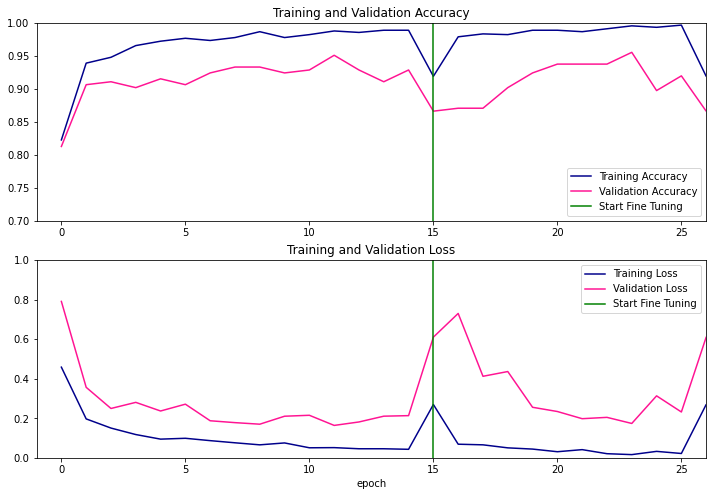

In [58]:
draw_plot(hist_inc, hist_inc_fine, fine_tune = True)

## Evaluation

In [81]:
loss, accuracy = model.evaluate(validation_generator)
print('Test accuracy :', accuracy * 100)

7/7 [==============================] - 8s 1s/step - loss: 0.2114 - accuracy: 0.9286
Test accuracy : 92.85714030265808


## Get Predictions

In [86]:
preds = model_inc.predict(validation_generator)
y_pred = np.argmax(preds, axis=1)

7/7 [==============================] - 9s 1s/step


## Confusion Matrics 

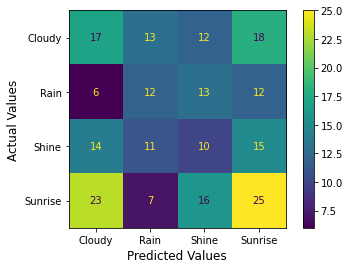

In [89]:
print_confusion_matrix(validation_generator, y_pred)

## Classification Report

In [88]:
print(classification_report(validation_generator.classes, y_pred, target_names= ['Cloudy', 'Rain', 'Shine', 'Sunrise']))

              precision    recall  f1-score   support

      Cloudy       0.28      0.28      0.28        60
        Rain       0.28      0.28      0.28        43
       Shine       0.20      0.20      0.20        50
     Sunrise       0.36      0.35      0.35        71

    accuracy                           0.29       224
   macro avg       0.28      0.28      0.28       224
weighted avg       0.29      0.29      0.29       224



## Save Model

In [ ]:
model_inc.save('model_inc.h5')